### Problem Statement

Rossmann is one of the largest drugstore chains in Germany, with
operations across Europe. As of 2018, they have well over 3,900 stores in
Europe with an annual turnover of 9 billion euros. Our task is to predict the
sales for a few identified stores on a given day.

# EDA

In [1]:
import pandas as pd
df = pd.read_csv("data/train.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Once we have the data imported, the first thing we need to explore is the length, breadth, and type of data.

In [3]:
print("Shape of the Dataset:",df.shape)


Shape of the Dataset: (1017209, 9)


In [4]:
#the head method displays the first 5 rows of the data
df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Similarly, let us import the second dataset, store.csv, and have a look at
its length, breadth, and the first 5 rows.

In [5]:
store = pd.read_csv("data/store.csv")
print("Shape of the Dataset:",store.shape)

Shape of the Dataset: (1115, 10)


In [6]:
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


* The train dataset has 1,017,209 rows and 9 columns.
* In the train dataset, we have data for stores on  different days. We have the total sales for the particular day and a couple of additional attributes.
* Likewise, the store data has 1,115 rows and 10 columns of data. It gives us additional store attributes that describe store features like assortment type, presence of competition, and promotion-related attributes.

# Looking at the Data Dictionary
Let us have a look at the data dictionary provided in the competition page
on Kaggle. 

* Sales: the turnover for any given day (target variable).
* Customers: the number of customers on a given day.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: indicates whether a store is running a promo on that day.
* StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.



* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

To have all the data points together, we need to create one single
dataframe with the store and promotion features. We can achieve this by
joining the two dataframes on the ‘store’ column, which represents the
store ID

In [7]:
df_new = df.merge(store,on=["Store"], how="inner")
print(df_new.shape)

(1017209, 18)


Now that we have the data in a unified form, let us start exploring the
dataset to understand a few important questions like the following: How
many stores do we have the data for? How long do we have the data for?
What do the average sales for a day look like? are the stores very different
from each other in daily sales? Let’s find out.
We will start by finding the number of unique stores in the data, the
number of unique days for which we have data, and the average sales for
all stores.

In [8]:
print("Distinct number of Stores :", len(df_new["Store"].
unique()))
print("Distinct number of Days :", len(df_new["Date"].
unique()))
print("Average daily sales of all stores : ",round(df_new
["Sales"].mean(),2))

Distinct number of Stores : 1115
Distinct number of Days : 942
Average daily sales of all stores :  5773.82


We can see that there are in total 1,115 unique stores with data for 942
unique days, with an average daily sale of 5,773.

In [9]:
df_new.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## Working with Time

In [10]:
# We now have a fair understanding of the Store column; let’s have a look at the DayOfWeek feature.
df_new["DayOfWeek"].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

As we would expect, we can see seven distinct values, with similar
numbers of records in each, for the “day of the week” feature. Given that
we already have the date as a feature, we could have directly used the date
column to create the day of the week and also create a few other features.
Let’s create additional features that will help our model learn patterns
better. We will create the week number, month, day, quarter, and year as
features from the date variable. Similarly, since we are already creating
time-related features, we can add a new feature based on climate and
seasons. Considering that the stores are in Europe, we can refer to the
standard season cycles and create a new season feature with values of
Spring, Summer, Fall, and Winter.

In [13]:
#We can extract all date properties from a datetime datatype
import numpy as np
df_new['Date'] = pd.to_datetime(df_new['Date'], infer_datetime_format=True)
df_new["Month"] = df_new["Date"].dt.month
df_new["Quarter"] = df_new["Date"].dt.quarter
df_new["Year"] = df_new["Date"].dt.year
df_new["Day"] = df_new["Date"].dt.day
df_new["Week"] = df_new["Date"].dt.week
df_new["Season"] = np.where(df_new["Month"].isin([3,4,5]),"Spring", 
                            np.where(df_new["Month"].isin([6,7,8]),
                                     "Summer",np.where(df_new["Month"].isin([9,10,11]),
                                                       "Fall",np.where(df_new["Month"].isin([12,1,2]),"Winter","None"))))



In [15]:
print(df_new[["Date","Year","Month","Day","Week","Quarter",
"Season"]].head())

        Date  Year  Month  Day  Week  Quarter  Season
0 2015-07-31  2015      7   31    31        3  Summer
1 2015-07-30  2015      7   30    31        3  Summer
2 2015-07-29  2015      7   29    31        3  Summer
3 2015-07-28  2015      7   28    31        3  Summer
4 2015-07-27  2015      7   27    31        3  Summer


# Predicting Sales

The next feature in the list is the Sales column. This is our target variable
(i.e., we are developing the model to predict the variable).

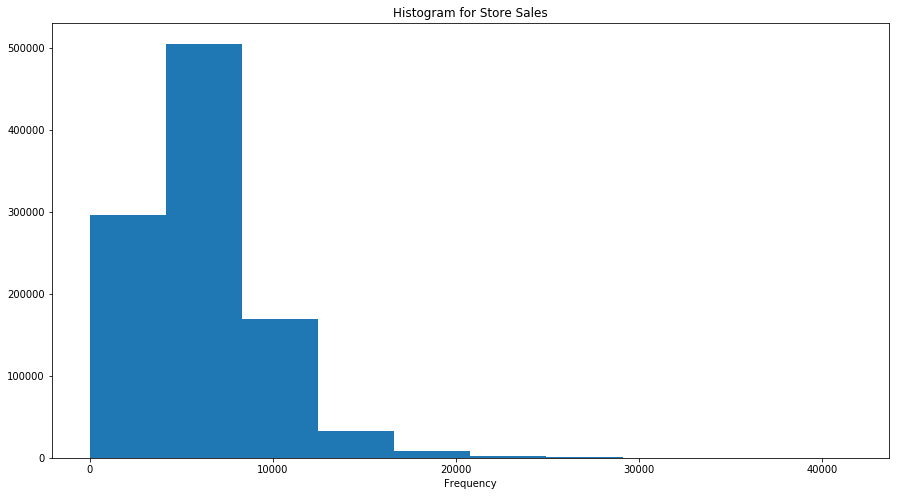

In [18]:

import matplotlib.pyplot as plt
%matplotlib inline
#Create a histogram to study the Daily Sales for the stores
plt.figure(figsize=(15,8))
plt.hist(df_new["Sales"])
plt.title("Histogram for Store Sales")
plt.xlabel("bins")
plt.xlabel("Frequency")
plt.show()

The histogram helps us understand the distribution of the data at a
high level. From the preceding plot, we can see that the data range is from
0 to 40,000, but there is barely any data after 20,000. This indicates that
most of the stores have sales in the range 0–20,000, and just a few stores
have sales greater than 20,000.

### Exploring Numeric Columns
Moving on, we have few more numeric columns to explore.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026EC93250F0>,
      dtype=object)

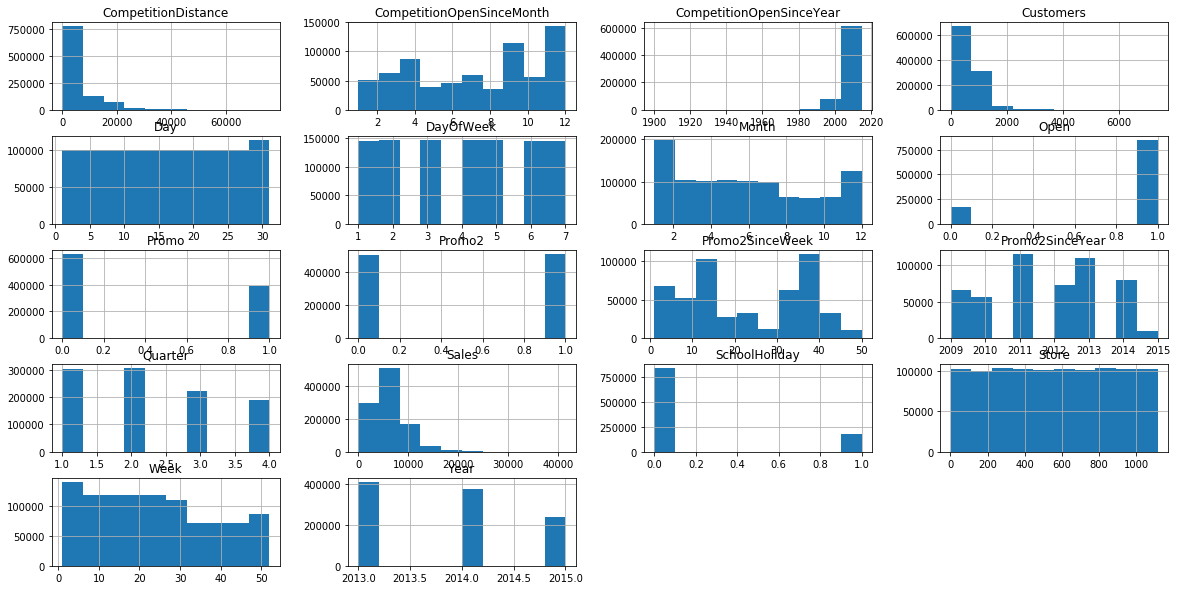

In [19]:
df_new.hist(figsize=(20,10))

Let’s analyze the results from the histogram showcased in the
preceding illustration. We can see that the features Promo, Promo2, School
Holiday, and Open are actually binary categorical features: they represent
two possible values similar to gender: Male or Female. Therefore, these
are actually categorical features but already encoded as numeric columns.
This is great; we won’t need to further process them, as DL models
understand only numeric values.


Promo2 is well distributed between the two distinct values, whereas
Promo has more records for ‘1’ and Open has most of the store records
as ‘1’. The distribution between the values for ‘Open’ makes sense, as the
stores will be open for most days except state holidays.
Customer numbers range from 0 to 2,000 for most stores. A few stores
have as many as 7000 daily customers, but these are outliers and we might
need to fix them before modeling.


The next set of numeric variables are Promo2SinceWeek and
Promo2SinceYear; these show a relatively well-distributed feature. The rest
of the histograms are pretty much self-explanatory.
We have missed checking on one important aspect: is there any
missing data in the dataset? The preceding plots usually don’t account for
missing values; instead, they exclude the null values in the plot.
Let’s have a look at the number of missing data points in each column
(if any) in its associated percentage form

In [20]:
df_new.isnull().sum()/df_new.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Month                         0.000000
Quarter                       0.000000
Year                          0.000000
Day                           0.000000
Week                          0.000000
Season                        0.000000
dtype: float64

In [22]:
#Replace nulls with the mode
df_new["CompetitionDistance"]=df_new["CompetitionDistance"].fillna(df_new["CompetitionDistance"].mode()[0])
#Double check if we still see nulls for the column
df_new["CompetitionDistance"].isnull().sum()/df_new.shape[0] * 100

0.0

# Understanding the Categorical Features

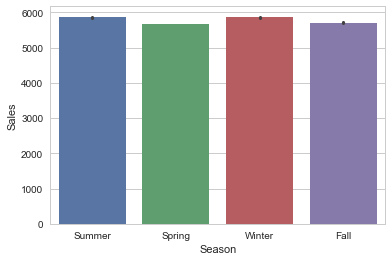

In [24]:
import seaborn as sns 
sns.set(style="whitegrid")
#Create the bar plot for Average Sales across different Seasons
ax = sns.barplot(x="Season", y="Sales", data=df_new)



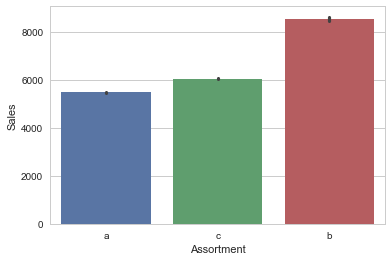

In [26]:
#Create the bar plot for Average Sales across different Assortments
ax = sns.barplot(x="Assortment", y="Sales", data=df_new)

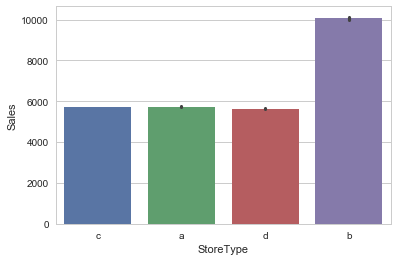

In [27]:
#Create the bar plot for Average Sales across different Store Types
ax = sns.barplot(x="StoreType", y="Sales", data=df_new)

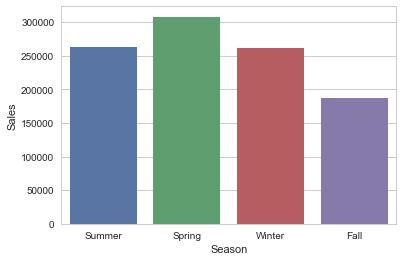

In [28]:
ax = sns.barplot(x="Season", y="Sales", data=df_new,estimator=np.size)

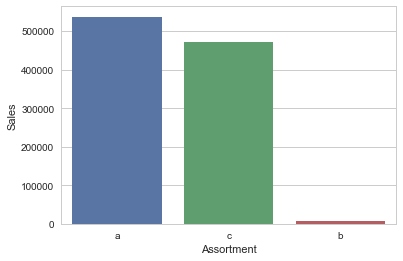

In [29]:
ax = sns.barplot(x="Assortment", y="Sales", data=df_new,estimator=np.size)

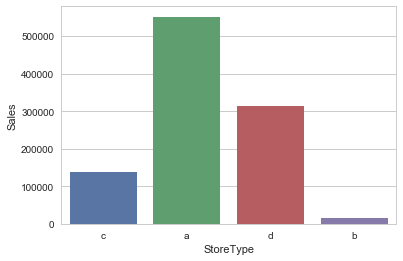

In [30]:
ax = sns.barplot(x="StoreType", y="Sales", data=df_new,estimator=np.size)

# Data Engineering

In [36]:
#Define a variable for each type of feature
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
target = ["Sales"]
numeric_columns = ["Customers","Open","Promo","Promo2","StateHoliday","SchoolHoliday","CompetitionDistance"]
categorical_columns = ["DayOfWeek","Quarter","Month","Year","StoreType","Assortment","Season"]

#Define a function that will intake the raw dataframe and thecolumn name and return a one hot encoded DF
def create_ohe(df, col):
    le = LabelEncoder()
    a=le.fit_transform(df_new[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    column_names = [col+ "_"+ str(i) for i in le.classes_]
    
    return (pd.DataFrame(ohe.fit_transform(a),columns =column_names))

#Since the above function converts the column, one at a time
#We create a loop to create the final dataset with all features
temp = df_new[numeric_columns]
for column in categorical_columns:
    temp_df = create_ohe(df_new,column)
    temp = pd.concat([temp,temp_df],axis=1)
print("Shape of Data:",temp.shape)
print("Distinct Datatypes:",temp.dtypes.unique())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

Shape of Data: (1017209, 44)
Distinct Datatypes: [dtype('int64') dtype('O') dtype('float64')]


In [37]:
print(temp.columns[temp.dtypes=="object"])

Index(['StateHoliday'], dtype='object')


In [38]:
temp["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [39]:
temp["StateHoliday"]= np.where(temp["StateHoliday"]== '0',0,1)
#One last check of the data type
temp.dtypes.unique()

array([dtype('int64'), dtype('int32'), dtype('float64')], dtype=object)

In [41]:
from sklearn.model_selection import train_test_split
#Create train and test dataset with an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(temp,df_new[target],test_size=0.2,random_state=2018)
#Further divide training dataset into train and validation dataset with an 90:10 split
x_train, x_val, y_train, y_val = train_test_split(x_train,
y_train,test_size=0.1,random_state=2018)
#Check the sizes of all newly created datasets
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (732390, 44)
Shape of x_val: (81377, 44)
Shape of x_test: (203442, 44)
Shape of y_train: (732390, 1)
Shape of y_val: (81377, 1)
Shape of y_test: (203442, 1)


# Defining Model Baseline Performance

In [42]:
#calculate the average score of the train dataset
mean_sales = y_train.mean()
print("Average Sales :",mean_sales)

Average Sales : Sales    5773.099997
dtype: float64


In [43]:
#Calculate the Mean Absolute Error on the test dataset
print("MAE for Test Data:",abs(y_test - mean_sales).mean()[0])

MAE for Test Data: 2883.587604303215


# Designing the DNN

In [45]:
#Create Deep Neural Network Architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(150,input_dim = 44,activation="relu"))
#The input_dim =44, since the width of the training data=44
model.add(Dense(1,activation = "linear"))
#Configure the model
model.compile(optimizer='adam',loss="mean_absolute_error",
metrics=["mean_absolute_error"])
#Train the model
model.fit(x_train.values,y_train.values, validation_data=
(x_val,y_val),epochs=10,batch_size=64)

Using TensorFlow backend.


Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 21s 28us/step - loss: 950.7851 - mean_absolute_error: 950.7851 - val_loss: 841.4921 - val_mean_absolute_error: 841.4921
Epoch 2/10
732390/732390 [==============================] - 21s 28us/step - loss: 782.5758 - mean_absolute_error: 782.5758 - val_loss: 755.2576 - val_mean_absolute_error: 755.2576
Epoch 3/10
732390/732390 [==============================] - 20s 28us/step - loss: 739.5569 - mean_absolute_error: 739.5569 - val_loss: 735.9725 - val_mean_absolute_error: 735.9725
Epoch 4/10
732390/732390 [==============================] - 21s 28us/step - loss: 721.6571 - mean_absolute_error: 721.6571 - val_loss: 707.6888 - val_mean_absolute_error: 707.6888
Epoch 5/10
732390/732390 [==============================] - 21s 29us/step - loss: 711.2473 - mean_absolute_error: 711.2473 - val_loss: 695.8538 - val_mean_absolute_error: 695.8538
Epoch 6/10
732390/732390 [=======================

# Testing the Model Performance

In [46]:
#Use the model's evaluate method to predict and evaluate the test datasets
result = model.evaluate(x_test.values,y_test.values)
#Print the results
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

203442/203442 [==============================] - 4s 18us/step
Metric  loss : 687.18
Metric  mean_absolute_error : 687.18


# Improving the Model

In [48]:
model = Sequential()
model.add(Dense(150,input_dim = 44,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(1,activation = "linear"))
model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])
history = model.fit(x_train,y_train, validation_data=(x_val,
y_val),epochs=10,batch_size=64)
#result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 41s 56us/step - loss: 1749587.7354 - mean_absolute_error: 857.5314 - val_loss: 1098672.7131 - val_mean_absolute_error: 720.1360
Epoch 2/10
732390/732390 [==============================] - 38s 52us/step - loss: 1151672.1942 - mean_absolute_error: 720.5371 - val_loss: 1032412.6134 - val_mean_absolute_error: 682.5777
Epoch 3/10
732390/732390 [==============================] - 39s 53us/step - loss: 1090359.4104 - mean_absolute_error: 700.2995 - val_loss: 1002400.1225 - val_mean_absolute_error: 676.5861
Epoch 4/10
732390/732390 [==============================] - 40s 54us/step - loss: 1053309.5934 - mean_absolute_error: 688.7831 - val_loss: 1035075.4280 - val_mean_absolute_error: 693.5445
Epoch 5/10
732390/732390 [==============================] - 39s 53us/step - loss: 1025104.7815 - mean_absolute_error: 679.9847 - val_loss: 987516.1061 - val_mean_absolute_error: 669.7405
Epoch 6/10

# Plotting the Loss Metric Across Epochs

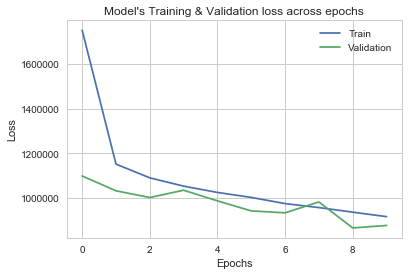

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Testing the Model Manually

In [50]:
#Manually predicting from the model, instead of using model's evaluate function
y_test["Prediction"] = model.predict(x_test)
y_test.columns = ["Actual Sales","Predicted Sales"]
print(y_test.head(10))

        Actual Sales  Predicted Sales
115563             0         3.865385
832654             0        -8.248617
769112          2933      3339.441650
350588          8602      7654.157715
141556          6975      6497.939941
84435           9239      8994.715820
53018              0         3.381916
262419             0         2.709422
702267          5885      5413.060547
981431             0        -4.005033


In [51]:
#Manually predicting from the model, instead of using model's evaluate function
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE :",mean_squared_error(y_test["Actual Sales"].values,y_test["Predicted Sales"].values))
print("MAE :",mean_absolute_error(y_test["Actual Sales"].values,y_test["Predicted Sales"].values))

MSE : 881435.1939209772
MAE : 641.8628538834777
